<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=500></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

# Проект по object detection.

<p style="text-align: center;"><i>Руководитель проекта: Илья Захаркин (Сколтех, МФТИ) | @ilyazakharkin</i></p>

## 0. Установка зависимостей.

In [1]:
import os
import cv2
import time
import json
import torch
import random
import requests
import torchvision
import numpy as np
from PIL import Image
import albumentations as alb
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from albumentations.pytorch import transforms as transforms

Расшифруем классы COCO датасета. Это пригодится для визуализации работы модели на тестовом датасете.

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2021-01-22 15:02:48--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.38.204
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.38.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  89.0MB/s    in 2.7s    

2021-01-22 15:02:51 (89.0 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
cat_2017 = './annotations/instances_val2017.json'

In [ ]:
coco_labels = {}
with open(cat_2017, 'r') as coco:
  js = json.loads(coco.read())
for i in range(len(js['categories'])):
  class_name = js['categories'][i]['name']
  class_id = js['categories'][i]['id']
  coco_labels[class_id] = class_name
print(coco_labels)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro


## 1. Выбор библиотеки для детектирования.

Для выполнения данного проекта руководитель рекомендует использовать одну из следующих библиотек:

1. torchvision.models.detection и torchhub;
2. mmdetection;
3. detectron2;
4. TensorFlow Object Detection API.

Я хочу попробовать реализовать нейросеть Mask R-CNN, так как она совмещает в себе сегментацию и детекцию. Эта нейросеть представлена во всех вышеперечисленных фреймворках:

1. torchvision.models.detection.mask_rcnn
2. https://github.com/open-mmlab/mmdetection/tree/master/configs/mask_rcnn
3. https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
4. https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

Я выберу torchvision.models.detection, так как данная библиотека была оптимизированна конкретно под Pytorch. 

## 2. Запуск детектора на случайных изображениях.

В этом разделе необходимо запустить выбранную модель с помощью выбранной библиотеки и протестировать ее на каком-либо изображении.

Загрузим предобученную модель:

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [ ]:
pretrained_model.to(DEVICE)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

Напишем код для детекции объектов на тестовом изображении:

Переведем модель в режим тестирования. Некоторые слои модели (такие как Dropout, BatchNormalization) ведут себя по-разному в eval и train режимах. В eval режиме Dropout слой не используется (проходящий слой). Про BatchNormalization в [документации](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d) сказано следущее:

*   During training, this layer keeps a running estimate of its computed mean and variance. The running sum is kept with a default momentum of 0.1.
*   During evaluation, this running mean/variance is used for normalization.

Несколько слов о различии eval() и torch.no_grad():
*   model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
*   torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).

In [ ]:
def predict(model, image):
  model.eval()
  with torch.no_grad():
    transform_test = torchvision.transforms.ToTensor()
    image = transform_test(image).unsqueeze(0)
    outputs = model(image.to(DEVICE))
  return outputs

Выберем тестовые изображения из датасета СОСО (будем использовать изображения, которые были на семинаре):

In [ ]:
images = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

In [ ]:
image = [Image.open(requests.get(url, stream=True).raw) for url in images]

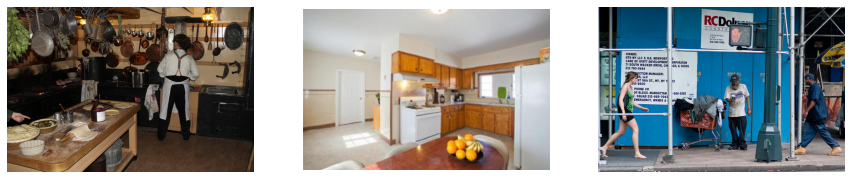

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,15)) 
for i in range(3):
  ax[i].imshow(image[i])
  ax[i].axis('off')
plt.show()

Предскажем объекты, находящиеся на этих изображениях:

In [ ]:
outputs = predict(pretrained_model, image[0])

Метод для визуализации результата на исходном изображении:

In [ ]:
def visualize_outputs(image, outputs, threshold, rect_thickness, text_size, text_thickness):
  # show initial image
  fig, ax = plt.subplots(1, 1, figsize=(15, 15))
  ax.axis('off')
  image = np.array(image)
  masks = outputs[0]['masks']
  for i in range(len(masks)):
    score = (outputs[0]['scores'][i].detach().cpu().numpy() * 100).round(2)
    if score > threshold:
      # semantic segmentation
      colored_mask = get_colored_mask(masks[i])
      image = cv2.addWeighted(image, 1, colored_mask, 0.5, 0.0)
      # detection boxes
      box = outputs[0]['boxes'][i].detach().cpu().numpy() # left, bottom, right, top
      cv2.rectangle(image, (int(box[0]), int(box[3])), (int(box[2]), int(box[1])), (0, 255, 0),  rect_thickness) # start point - top left corner, stop point - bottom right corner
      # labels 
      label = outputs[0]['labels'][i].detach().cpu().numpy()
      label = coco_labels[int(label)]
      cv2.putText(image, '{}: {}%'.format(label, score), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_thickness)
  ax.imshow(image)
  plt.show()

Маски будут визуализироваться в виде разноцветных заполненных областей:

In [ ]:
def get_colored_mask(mask):
  mask = mask.squeeze().detach().cpu().numpy()
  mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)
  color = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
  r, g, b = [np.where(mask == 1, color[j], 0) for j in range(3)]
  return np.stack([r, g, b], axis=2).astype(np.uint8)

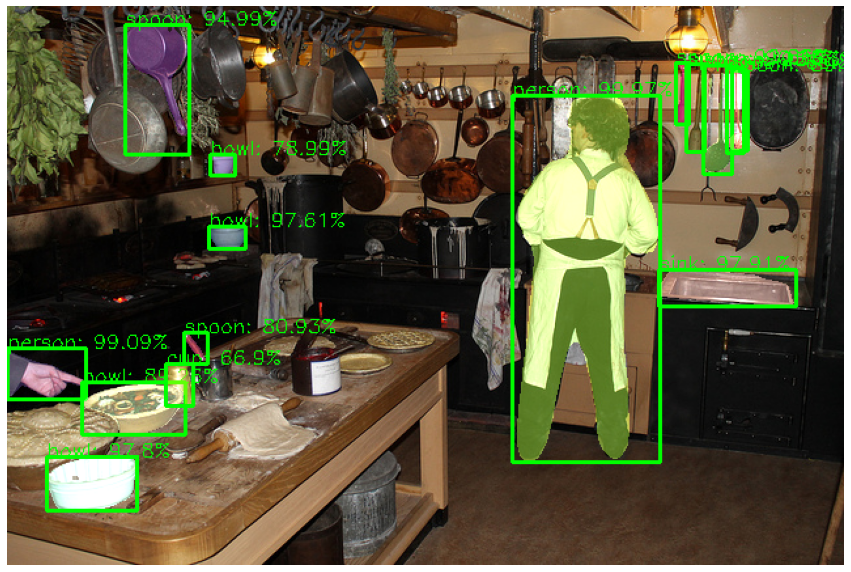

In [ ]:
visualize_outputs(image[0], outputs, 60, 2, 0.5, 1)

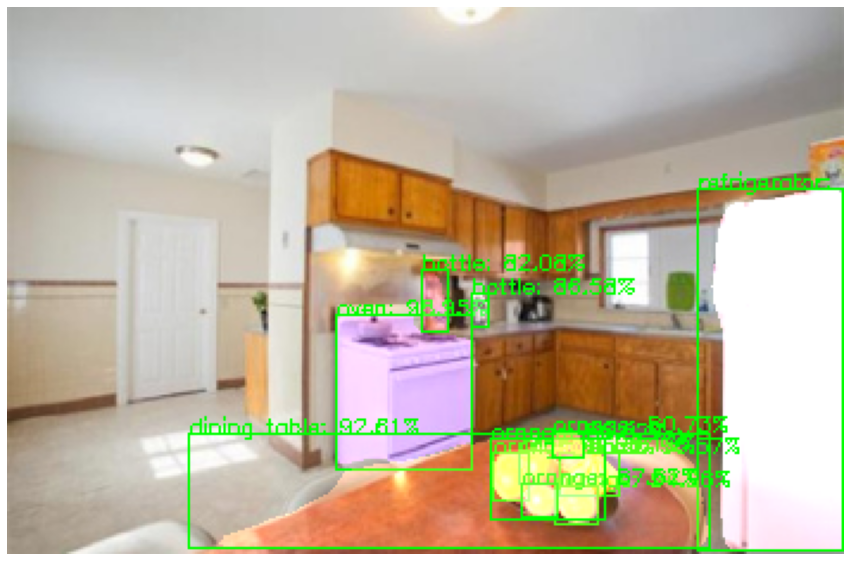

In [ ]:
outputs = predict(pretrained_model, image[1])
visualize_outputs(image[1], outputs, 80, 1, 0.3, 1)

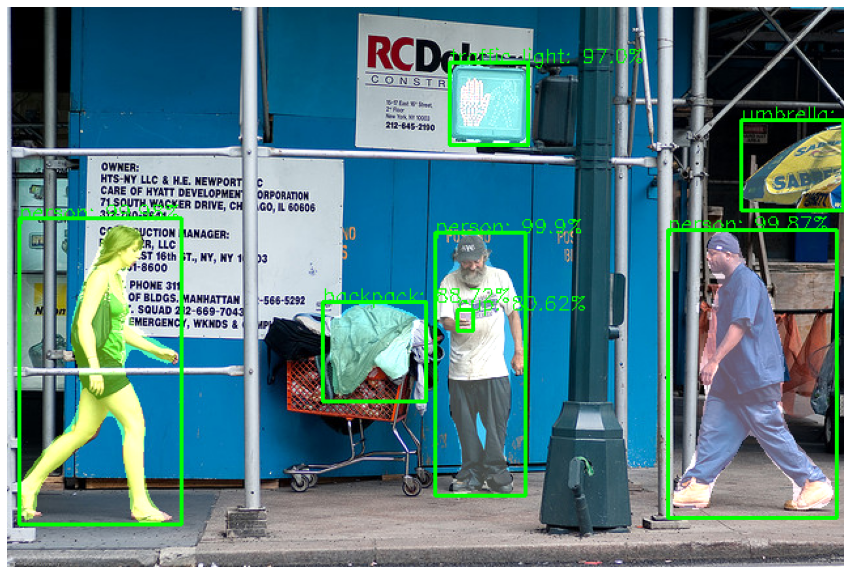

In [ ]:
outputs = predict(pretrained_model, image[2])
visualize_outputs(image[2], outputs, 80, 2, 0.5, 1)

## 3. Выбор датасета для обучения.

В качестве датасета я буду использовать [датасет клеток](https://www.kaggle.com/c/data-science-bowl-2018/data). Данные я предварительно распаковала, удалила ненужные папки, которые использовались для соревнования, и загрузила на Google Drive.

In [4]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Данный датасет предназначен для сегментации, поэтому bounding boxes будут составлены вручную в пункте "Предобработка данных".

## 4. Предобработка данных.

Определим основные характеристики датасета:

In [99]:
TRAIN_PATH = '/content/gdrive/MyDrive/DLS/nuclei/stage1_train'
TEST_PATH = '/content/gdrive/MyDrive/DLS/nuclei/stage1_test'

train_val_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

print('Number of train val images:', len(train_val_ids))
print('Number of test images:', len(test_ids))

Number of train val images: 670
Number of test images: 65


In [100]:
random.shuffle(train_val_ids)
train_ids = train_val_ids[:550]
val_ids1 = train_val_ids[550:610]
val_ids2 = train_val_ids[610:]
print('Number of train images:', len(train_ids))
print('Number of val images:', len(val_ids1))
print('Number of test images:', len(val_ids2))

Number of train images: 550
Number of val images: 60
Number of test images: 60


В этом пункте нужно подготовить генератор батчей изображений, начнем с построения датасета. Данный класс является модификацией класса из [официального туториала torchvision](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [101]:
RESCALE_SIZE = 256
class NucleiDataset(object):
    def __init__(self, mode, get_initial_image):
        self.mode = mode
        self.get_initial_image = get_initial_image
        if self.mode == 'train':
          self.image_paths = train_ids
        elif self.mode == 'val':
          self.image_paths = val_ids1
        elif self.mode == 'val2': # датасет для оценки качества работы модели
          self.image_paths = val_ids2
        else:
          self.image_paths = test_ids
        self.root_path = TEST_PATH if self.mode == 'test' else TRAIN_PATH

    def load_sample(self, idx):
        # get image
        image_path = os.path.join(self.root_path, self.image_paths[idx], 'images',
                                  '{}.png'.format(self.image_paths[idx]))
        image = cv2.imread(image_path)
        image = cv2.normalize(image, None, alpha=0, beta=1, 
                              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # get masks
        mask_path = os.path.join(self.root_path, self.image_paths[idx], 'masks')
        mask_ids = next(os.walk(mask_path))[2]
        masks = [cv2.imread(os.path.join(mask_path, mask_path_), 0) \
                  for mask_path_ in mask_ids]
        masks = [cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, 
                               dtype=cv2.CV_32F) for mask in masks]
        return image, masks

    def get_bb(self, masks):
        # get bounding boxes
        boxes = []
        new_masks = []
        for i in range(len(masks)):
            pos = np.where(masks[i])
            if len(pos[0]) > 0: 
                left, right = np.min(pos[1]), np.max(pos[1])
                top, bottom = np.max(pos[0]), np.min(pos[0])
                if left == right: # для плоских клеток иногда боксы слипаются в линию
                    right += 1
                if bottom == top:
                    top += 1
                boxes.append([left, bottom, right, top])
                new_masks.append(masks[i])
        return new_masks, boxes

    def __getitem__(self, idx):
        initial_image, masks = self.load_sample(idx)
        # transform to tensor and apply augmentations if needed
        if self.mode == 'train':
            apply_transform = alb.Compose([
                                          alb.Resize(RESCALE_SIZE, RESCALE_SIZE),
                                          alb.HorizontalFlip(p=0.5),
                                          # alb.Rotate(30, p=0.5), # из-за аугментаций иногда получались изображения без клеток
                                          transforms.ToTensor()])
        else:
            apply_transform = alb.Compose([
                                          alb.Resize(RESCALE_SIZE, RESCALE_SIZE),
                                          transforms.ToTensor()])
        transformed = apply_transform(image=initial_image, masks=masks)
        image, masks = transformed['image'], transformed['masks']
        masks, boxes = self.get_bb(masks)
        target = {}
        target["image_id"] = torch.tensor([idx])
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32) # dtype в требованиях к инпуту модели
        target["labels"] = torch.ones((len(masks),), dtype=torch.int64)
        target["masks"] = torch.tensor(masks, dtype=torch.uint8)
        if self.get_initial_image == True:
          return initial_image, image, target
        else:
          return image, target

    def __len__(self):
        return len(self.image_paths)

Генератор батчей:

In [102]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
BATCH_SIZE = 2
dataset = NucleiDataset('train', True)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                      shuffle=True, collate_fn=collate_fn)

Проверим результат генерации:

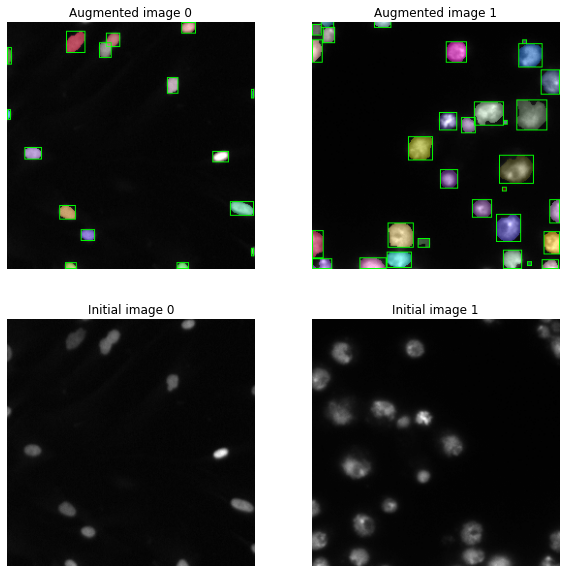

In [ ]:
for initial_image, image, targets in loader:
  ax_number = len(image)
  fig, ax = plt.subplots(2, ax_number, figsize=(10, 10))
  for i in range(ax_number):
    for f in range(2):
      ax[f][i].axis('off')
  for j, img in enumerate(image):
    img = img.squeeze(0).numpy()
    img = img.transpose(1,2,0)
    img = (img * 255).astype('uint8')
    masks = targets[j]['masks']
    for k in range(len(masks)):
      # get colored mask
      mask = masks[k].squeeze(0).numpy()
      color = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
      r, g, b = [np.where(mask == 1, color[m], 0) for m in range(3)]
      colored_mask =  np.stack([r, g, b], axis=2).astype(np.uint8)
      # semantic segmentation
      img = cv2.addWeighted(img, 1, colored_mask, 0.5, 0.0)
      # detection boxes
      box = targets[j]['boxes'][k] # left, bottom, right, top
      cv2.rectangle(img, (int(box[0]), int(box[3])), (int(box[2]), int(box[1])), (0, 255, 0),  1)
    ax[0, j].imshow(img)
    ax[0, j].set_title('Augmented image {}'.format(j))
    ax[1, j].imshow(initial_image[j])
    ax[1, j].set_title('Initial image {}'.format(j))
  plt.show()
  break

## 5. Обучение модели.

Определим обучающий и валидационный датасеты:

In [ ]:
train_dataset = NucleiDataset('train', False)
val_dataset = NucleiDataset('val', False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, collate_fn=collate_fn)

Определим модель и отправим ее на GPU. Так как датасет клеток существенно отличается от датасета COCO и в нем только один класс, то предобученную модель брать не будем, попробуем обучить ее с нуля.

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, num_classes=2) # num_classes including background
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

Метод для обучения модели:

In [ ]:
def train(model, train_loader, optimizer, device, lr_scheduler=None):
  running_loss = 0.0
  processed_data = 0
  for images, targets in train_loader:
      torch.cuda.empty_cache()
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      train_loss_dict = model(images, targets) # loss_classifier, loss_box_reg, loss_mask, loss_objectness, loss_rpn_box_reg
      train_loss = sum(loss for loss in train_loss_dict.values())
      running_loss += train_loss.detach().cpu().numpy()
      processed_data += len(images)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
      if lr_scheduler is not None:
          lr_scheduler.step()
  loss = running_loss / processed_data
  return loss

Метод для оценки модели на валидационных данных. В данной реализации Mask RCNN при переводе модели в eval режим лоссы можно получить, только если вручную изменить файлы torchvision. В обычном состоянии eval возвращает только предсказания. Поэтому для получения лоссов в данном методе мы будем все также использовать train режим, но без расчета градиентов. [Ссылка на похожее обсуждение](https://discuss.pytorch.org/t/compute-validation-loss-for-faster-rcnn/62333/7).

In [ ]:
def evaluate(model, val_loader, device):
    running_loss = 0.0
    processed_data = 0
    for val_images, val_targets in val_loader:
        torch.cuda.empty_cache()
        images = list(image.to(device) for image in val_images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]
        with torch.no_grad():
            val_loss_dict = model(images, targets)
            val_loss = sum(loss for loss in val_loss_dict.values())
            running_loss += val_loss.detach().cpu().numpy()
            processed_data += len(images)
    loss = running_loss / processed_data
    return loss

Параметры обучения:

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)
EPOCHS = 75

Обучим модель:

In [ ]:
history = []
model.train()
log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
with tqdm(desc="epoch", total=EPOCHS) as pbar_outer:
    for epoch in range(EPOCHS):
        torch.cuda.empty_cache()
        train_loss = train(model, train_loader, optimizer, DEVICE)
        val_loss = evaluate(model, val_loader, DEVICE)
        history.append((train_loss, val_loss))
        if (epoch > 0): # сохраняем модель
            torch.save(model, '/content/gdrive/MyDrive/DLS/nuclei/best_model_{}.pth'.format(epoch))
            np.save('/content/gdrive/MyDrive/DLS/nuclei/train_history_{}.npy'.format(epoch), history)
        if epoch == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
        if epoch == 50:
            optimizer.param_groups[0]['lr'] = 1e-6
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss, v_loss=val_loss))
np.save('/content/gdrive/MyDrive/DLS/nuclei/train_history_full.npy', history)

epoch:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
epoch:   1%|▏         | 1/75 [1:51:02<136:57:11, 6662.59s/it]


Epoch 001 train_loss: 0.7800 val_loss 0.5561


epoch:   3%|▎         | 2/75 [1:58:55<97:26:47, 4805.58s/it]


Epoch 002 train_loss: 0.5489 val_loss 0.4985


epoch:   4%|▍         | 3/75 [2:06:42<70:04:55, 3504.11s/it]


Epoch 003 train_loss: 0.4944 val_loss 0.4686


epoch:   5%|▌         | 4/75 [2:14:32<51:09:19, 2593.79s/it]


Epoch 004 train_loss: 0.4740 val_loss 0.4939


epoch:   7%|▋         | 5/75 [2:22:19<38:01:52, 1955.89s/it]


Epoch 005 train_loss: 0.4610 val_loss 0.4345


epoch:   8%|▊         | 6/75 [2:30:06<28:55:27, 1509.09s/it]


Epoch 006 train_loss: 0.4420 val_loss 0.4388


epoch:   9%|▉         | 7/75 [2:37:57<22:37:25, 1197.72s/it]


Epoch 007 train_loss: 0.4276 val_loss 0.4487


epoch:  11%|█         | 8/75 [2:45:45<18:12:54, 978.73s/it]


Epoch 008 train_loss: 0.4211 val_loss 0.4241


epoch:  12%|█▏        | 9/75 [2:53:35<15:08:44, 826.14s/it]


Epoch 009 train_loss: 0.4072 val_loss 0.4254


epoch:  13%|█▎        | 10/75 [3:01:23<12:58:31, 718.64s/it]


Epoch 010 train_loss: 0.4001 val_loss 0.4292


epoch:  15%|█▍        | 11/75 [3:09:10<11:26:09, 643.27s/it]


Epoch 011 train_loss: 0.3930 val_loss 0.4163


epoch:  16%|█▌        | 12/75 [3:17:00<10:20:59, 591.42s/it]


Epoch 012 train_loss: 0.3896 val_loss 0.4159


epoch:  17%|█▋        | 13/75 [3:24:47<9:32:26, 553.98s/it]


Epoch 013 train_loss: 0.3802 val_loss 0.4142


epoch:  19%|█▊        | 14/75 [3:32:43<8:59:28, 530.64s/it]


Epoch 014 train_loss: 0.3667 val_loss 0.3974


epoch:  20%|██        | 15/75 [3:40:40<8:34:36, 514.61s/it]


Epoch 015 train_loss: 0.3682 val_loss 0.4076


epoch:  21%|██▏       | 16/75 [3:48:30<8:12:52, 501.22s/it]


Epoch 016 train_loss: 0.3619 val_loss 0.4164


epoch:  23%|██▎       | 17/75 [3:56:17<7:54:26, 490.79s/it]


Epoch 017 train_loss: 0.3548 val_loss 0.4154


epoch:  24%|██▍       | 18/75 [4:04:04<7:39:28, 483.65s/it]


Epoch 018 train_loss: 0.3461 val_loss 0.4190


epoch:  25%|██▌       | 19/75 [4:11:54<7:27:33, 479.52s/it]


Epoch 019 train_loss: 0.3443 val_loss 0.4134


epoch:  27%|██▋       | 20/75 [4:19:42<7:16:34, 476.26s/it]


Epoch 020 train_loss: 0.3372 val_loss 0.4177


epoch:  28%|██▊       | 21/75 [4:27:31<7:06:29, 473.88s/it]


Epoch 021 train_loss: 0.3327 val_loss 0.4193


epoch:  29%|██▉       | 22/75 [4:35:19<6:57:11, 472.30s/it]


Epoch 022 train_loss: 0.3268 val_loss 0.4322


epoch:  31%|███       | 23/75 [4:43:12<6:49:22, 472.35s/it]


Epoch 023 train_loss: 0.3191 val_loss 0.4126


epoch:  32%|███▏      | 24/75 [4:51:02<6:40:52, 471.63s/it]


Epoch 024 train_loss: 0.3129 val_loss 0.4181


epoch:  33%|███▎      | 25/75 [4:58:50<6:32:13, 470.67s/it]


Epoch 025 train_loss: 0.3097 val_loss 0.4149


epoch:  35%|███▍      | 26/75 [5:06:39<6:23:52, 470.05s/it]


Epoch 026 train_loss: 0.3025 val_loss 0.4395


epoch:  36%|███▌      | 27/75 [5:14:27<6:15:31, 469.40s/it]


Epoch 027 train_loss: 0.2688 val_loss 0.4151


epoch:  37%|███▋      | 28/75 [5:22:15<6:07:29, 469.15s/it]


Epoch 028 train_loss: 0.2573 val_loss 0.4174


epoch:  39%|███▊      | 29/75 [5:30:04<5:59:33, 469.00s/it]


Epoch 029 train_loss: 0.2525 val_loss 0.4202


epoch:  40%|████      | 30/75 [5:37:51<5:51:22, 468.51s/it]


Epoch 030 train_loss: 0.2451 val_loss 0.4374


epoch:  41%|████▏     | 31/75 [5:45:36<5:42:49, 467.49s/it]


Epoch 031 train_loss: 0.2420 val_loss 0.4340


epoch:  43%|████▎     | 32/75 [5:53:22<5:34:40, 466.99s/it]


Epoch 032 train_loss: 0.2369 val_loss 0.4370


epoch:  44%|████▍     | 33/75 [6:01:07<5:26:31, 466.46s/it]


Epoch 033 train_loss: 0.2348 val_loss 0.4390


epoch:  45%|████▌     | 34/75 [6:08:55<5:18:53, 466.67s/it]


Epoch 034 train_loss: 0.2304 val_loss 0.4408


epoch:  47%|████▋     | 35/75 [6:16:41<5:11:05, 466.64s/it]


Epoch 035 train_loss: 0.2258 val_loss 0.4479


epoch:  48%|████▊     | 36/75 [6:24:28<5:03:23, 466.75s/it]


Epoch 036 train_loss: 0.2244 val_loss 0.4513


epoch:  49%|████▉     | 37/75 [6:32:20<4:56:35, 468.29s/it]


Epoch 037 train_loss: 0.2202 val_loss 0.4527


epoch:  51%|█████     | 38/75 [6:40:07<4:48:32, 467.92s/it]


Epoch 038 train_loss: 0.2178 val_loss 0.4514


epoch:  52%|█████▏    | 39/75 [6:47:54<4:40:37, 467.70s/it]


Epoch 039 train_loss: 0.2158 val_loss 0.4603


epoch:  53%|█████▎    | 40/75 [6:55:43<4:33:05, 468.16s/it]


Epoch 040 train_loss: 0.2114 val_loss 0.4599


epoch:  53%|█████▎    | 40/75 [6:57:00<6:04:53, 625.52s/it]


KeyboardInterrupt: ignored

Остановим обучение, так как видно, что модель переобучается. Скорее всего, переобучение связано с малым количеством аугментаций. Ввиду ограниченного времени для сдачи данного проекта, переобучение будет исправлено уже в ходе самостоятельной работы после окончания курса.

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/DLS/nuclei/best_model_full.pth')

In [ ]:
np.save('/content/gdrive/MyDrive/DLS/nuclei/train_history_full.npy', history)

Построим график функции потерь:

In [ ]:
history = np.load('/content/gdrive/MyDrive/DLS/nuclei/train_history_full.npy')

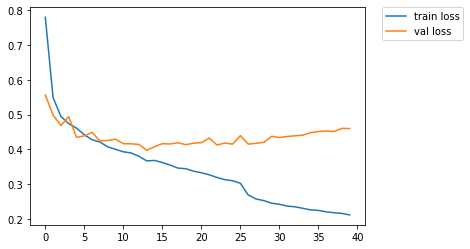

In [ ]:
plt.plot(history[:, :1].squeeze(), label="train loss")
plt.plot(history[:, 1:].squeeze(), label="val loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

По графику и выходным лоссам обучения видно, что переобучение стало наступать на 8 эпохе. Загрузим веса модели и протестируем ее на тестовом датасете.

## 6. Измерение качества работы модели.

Загрузим модель с весами на момент 8 эпохи обучения:

In [10]:
saved_model = torch.load('/content/gdrive/MyDrive/DLS/nuclei/best_model_8.pth')

Создадим тестовый датасет:

In [103]:
test_dataset = NucleiDataset('val2', False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, collate_fn=collate_fn)

Напишем функцию оценки качества работы модели:

In [132]:
def evaluate_model(model, device, iou_threshold):
  model.eval()
  ious, recalls, precisions, fs = [], [], [], []
  for test_images, test_targets in test_loader:
      targets, predictions = get_predictions(model, device)
      for i in range(BATCH_SIZE):
          target_bbox = targets[i]['boxes'].detach().cpu().numpy()
          prediction_bbox = predictions[i]['boxes'].detach().cpu().numpy()

          ious_, target_index, prediction_index  = [], [], []
          for m, prediction_box in enumerate(prediction_bbox):
              for n, target_box in enumerate(target_bbox):
                  iou = get_iou(target_box, prediction_box)
                  if iou >= iou_threshold:
                      ious_.append(iou)
                      target_index.append(n)
                      prediction_index.append(m)
          iou_sort = np.argsort(ious_)[::1]
          recall, precision, f1 = get_recall_precision(iou_sort, target_index, prediction_index, target_bbox, prediction_bbox)
          ious.append(np.mean(ious_))
          recalls.append(recall)
          precisions.append(precision)
          fs.append(f1)
  return ious, recalls, precisions, fs

Функция получения предсказаний и реальных значений:

In [133]:
saved_model.eval()
def get_predictions(model, device):
    torch.cuda.empty_cache()
    images = list(image.to(device) for image in test_images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in test_targets]
    with torch.no_grad():
        predictions = model(images)
    return targets, predictions

Метрика IoU:

In [134]:
def get_iou(target_bbox, prediction_bbox):
    x_top_left_target, y_top_left_target, x_bottom_right_target, y_bottom_right_target = target_bbox
    x_top_left_prediction, y_top_left_prediction, x_bottom_right_prediction, y_bottom_right_prediction = prediction_bbox

    if (x_bottom_right_target < x_top_left_prediction) or (y_bottom_right_target < y_top_left_prediction) or (x_top_left_target > x_bottom_right_prediction) or (y_top_left_target> y_bottom_right_prediction):
        return 0.0
    
    target_bbox_area = (x_bottom_right_target - x_top_left_target + 1) * (y_bottom_right_target - y_top_left_target + 1)
    prediction_bbox_area =(x_bottom_right_prediction - x_top_left_prediction + 1 ) * (y_bottom_right_prediction - y_top_left_prediction + 1)
    
    x_top_left = np.max([x_top_left_target, x_top_left_prediction])
    y_top_left = np.max([y_top_left_target, y_top_left_prediction])
    x_bottom_right = np.min([x_bottom_right_target, x_bottom_right_prediction])
    y_bottom_right = np.min([y_bottom_right_target, y_bottom_right_prediction])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right - y_top_left + 1)
    union_area = (target_bbox_area + prediction_bbox_area - intersection_area)
    return intersection_area/union_area

Метрики recall и precision:

In [135]:
def get_recall_precision(iou_sort, target_index, prediction_index, target_bbox, prediction_bbox):
    if len(iou_sort) == 0:
        recall, precision, f1 = 0, 0, 0
    else:
        target_match_index, prediction_match_index = [], []
        for index in iou_sort:
            target_idx = target_index[index]
            prediction_idx = prediction_index[index]
            if (target_idx not in target_match_index) and (prediction_idx not in prediction_match_index):
                target_match_index.append(target_idx)
                prediction_match_index.append(prediction_idx)
        tp = len(target_match_index)
        fp = len(prediction_bbox) - len(prediction_match_index)
        fn = len(target_bbox) - len(target_match_index)
        try:
            recall = tp / (tp + fn)
        except ZeroDivisionError:
            recall = 0
        try:
            precision = tp / (tp + fp)
        except ZeroDivisionError:
            precision = 0
        try:
            f1 = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            f1 = 0
    return recall, precision, f1

Получим результаты оценки качества модели:

In [136]:
ious, recalls, precisions, f1 = evaluate_model(saved_model, DEVICE, iou_threshold=0.5)

In [139]:
print('IoU: ', np.mean(ious).round(2))
print('Recall: ', np.mean(recalls).round(2))
print('Precision: ', np.mean(precisions).round(2))
print('F1: ', np.mean(f1).round(2))

IoU:  0.85
Recall:  1.0
Precision:  0.56
F1:  0.71


## 7. Применение модели в реальных задачах.

Модель для детекции и сегментации клеток может быть полезна в:

1) ускорении постановки диагноза, например, дифференциальная диагностика рака;

2) автоматизации выполнения некоторых анализов, например, при обучении на датасете с разными кровяными клетками можно выполнять автоматический подсчет лейкоцитов, тромбоцитов, эритроцитов и т.д.;

3) ускорении тестирования лекарств - при исследованиях действия лекарств на определенные типы клеток можно оценивать изменение клетки после применения лекарства, т.е. определять биологические процессы, которые запустились лекарством. На основе этого можно сделать вывод о лекарственном эффекте.